In [2]:
import pandas as pd
import numpy as np
import sys
import math

# Review Count Results for Sample Size Simulation

In [3]:
input_str='~/Documents/data/jurity_tests/simulations/sample_size/min_weight_0/{0}_simulation_count_{1}_surrogates_{2}.csv'
sim_names=["fair","slightly_unfair","moderately_unfair","very_unfair","extremely_unfair"]
color_map={"fair":"0.9","slightly_unfair":"0.8","moderately_unfair":"0.45","very_unfair":"0.3","extremely_unfair":"0"}
all_simulations=[]
avg_counts=[5,10,20,30,40]
num_surrogates=[50,100,300,400,500,1000]
for name in sim_names:
    for c in avg_counts:
        for n_surrogates in num_surrogates:
            all_simulations.append(pd.read_csv(input_str.format(name,c,n_surrogates)))
simulations_raw=pd.concat(all_simulations).drop(columns=["Unnamed: 0"])
simulations_raw=simulations_raw[simulations_raw["Metric"].apply(lambda x: x in ['Average Odds', 'Equal Opportunity', 'Predictive Equality','Statistical Parity'])]
print(simulations_raw.shape)
print('Pandas Dataframe of Raw Simulation Output')
simulations_raw.head()

(17760, 7)
Pandas Dataframe of Raw Simulation Output


,Metric,oracle_value,probabilistic_estimate,run_id,average_count,n_surrogates,simulation
0,Average Odds,-0.136,-0.380,0,5,50,fair
1,Equal Opportunity,-0.259,-0.730,0,5,50,fair
3,Predictive Equality,-0.013,-0.030,0,5,50,fair
4,Statistical Parity,-0.112,-0.213,0,5,50,fair
5,Average Odds,-0.016,0.089,1,5,50,fair


In [4]:
print("For Some Simulations, Samples are So Small There Are No Results")
simulations_raw["oracle_value"].apply(np.isnan).sum()

For Some Simulations, Samples are So Small There Are No Results


12

For Very Small Samples, Oracle Metric Might Require Dividing by 0, Also Resulting in NaN


<Axes: >

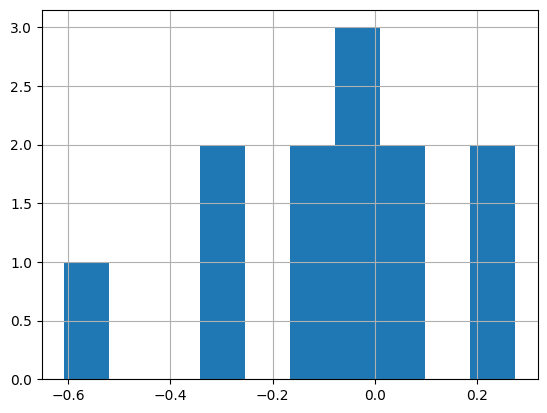

In [5]:
print("For Very Small Samples, Oracle Metric Might Require Dividing by 0, Also Resulting in NaN")
simulations_raw[simulations_raw["oracle_value"].apply(np.isnan)]["probabilistic_estimate"].hist()

In [6]:
print("Oracle Values for Each Simulation Setting")
means=simulations_raw.groupby(["Metric","simulation"])["oracle_value"].mean()
means.name="oracle_mean"
means


Oracle Values for Each Simulation Setting


Metric               simulation       
Average Odds         extremely_unfair    -0.352455
                     fair                 0.001236
                     moderately_unfair   -0.274491
                     slightly_unfair     -0.176544
                     very_unfair         -0.375599
Equal Opportunity    extremely_unfair    -0.553894
                     fair                 0.002168
                     moderately_unfair   -0.350130
                     slightly_unfair     -0.253854
                     very_unfair         -0.554526
Predictive Equality  extremely_unfair    -0.150985
                     fair                 0.000279
                     moderately_unfair   -0.198871
                     slightly_unfair     -0.099238
                     very_unfair         -0.196687
Statistical Parity   extremely_unfair    -0.470866
                     fair                 0.001082
                     moderately_unfair   -0.333723
                     slightly_unfair     -0

In [7]:
print("Analyzing Studentized Residuals: Requires Calculating Standard Deviations")
oracle_variance=simulations_raw.groupby(["Metric","simulation","average_count","n_surrogates"])["oracle_value"].agg(['var','std','count'])
oracle_variance.name="oracle_var"
oracle_variance

Analyzing Studentized Residuals: Requires Calculating Standard Deviations


var  \
Metric             simulation       average_count n_surrogates             
Average Odds       extremely_unfair 5             100           0.017607   
                                                  300           0.004033   
                                                  400           0.002782   
                                                  500           0.003538   
                                                  1000          0.002028   
...                                                                  ...   
Statistical Parity very_unfair      40            100           0.000387   
                                                  300           0.000161   
                                                  400           0.000097   
                                                  500           0.000056   
                                                  1000          0.000028   

                                                                     std  \
Metric             simulation       average_count n_surrogates             
Average Odds       extremely_unfair 5             100           0.132693   
                                                  300           0.063509   
                                                  400           0.052742   
                                                  500           0.059485   
                                                  1000          0.045033   
...                                                                  ...   
Statistical Parity very_unfair      40            100           0.019664   
                                                  300           0.012682   
                                                  400           0.009836   
                                                  500           0.007464   
                                                  1000          0.005270   

                                                                count  
Metric             simulation       average_count n_surrogates         
Average Odds       extremely_unfair 5             100              30  
                                                  300              30  
                                                  400              30  
                                                  500              30  
                                                  1000             30  
...                                                               ...  
Statistical Parity very_unfair      40            100              30  
                                                  300              30  
                                                  400              30  
                                                  500              30  
                                                  1000             30  

[592 rows x 3 columns]

In [8]:
print("Review When Oracle Fails to Return a Value")
oracle_variance[oracle_variance["count"]<30]

Review When Oracle Fails to Return a Value


,,,,var,std,count
Metric,simulation,average_count,n_surrogates,,,
Average Odds,slightly_unfair,5,50,0.026856,0.163878,26
Equal Opportunity,slightly_unfair,5,50,0.103019,0.320966,26
Predictive Equality,slightly_unfair,5,50,0.003498,0.059145,26


In [9]:
print("Standard Errors for Metrics Requires Degrees of Freedom")
print("Degrees of Freedom is the Number of Parameters Needed to Calculate the Metric")
df_index=pd.Series(["Average Odds","Equal Opportunity","Predictive Equality","Statistical Parity"])
df_index.name="Metric"
df=pd.DataFrame({"df":[16,8,8,8]},
                index=df_index)
df

Standard Errors for Metrics Requires Degrees of Freedom
Degrees of Freedom is the Number of Parameters Needed to Calculate the Metric


,df
Metric,
Average Odds,16
Equal Opportunity,8
Predictive Equality,8
Statistical Parity,8


In [10]:
standard_deviations=pd.DataFrame(oracle_variance).merge(df,left_index=True,right_index=True).merge(means,left_index=True,right_index=True).rename(columns={"var":"oracle_var","std":"oracle_std"})

standard_deviations["prob_standard_deviation"]=(standard_deviations["oracle_var"]*(standard_deviations["count"]-1)/(standard_deviations["count"]-standard_deviations["df"])).apply(np.sqrt)
standard_deviations["oracle_sum_of_squares"]=standard_deviations["oracle_var"]*(standard_deviations["count"]-1)

standard_deviations


oracle_var  \
Metric             simulation       average_count n_surrogates               
Average Odds       extremely_unfair 5             100             0.017607   
                                                  300             0.004033   
                                                  400             0.002782   
                                                  500             0.003538   
                                                  1000            0.002028   
...                                                                    ...   
Statistical Parity very_unfair      40            100             0.000387   
                                                  300             0.000161   
                                                  400             0.000097   
                                                  500             0.000056   
                                                  1000            0.000028   

                                                                oracle_std  \
Metric             simulation       average_count n_surrogates               
Average Odds       extremely_unfair 5             100             0.132693   
                                                  300             0.063509   
                                                  400             0.052742   
                                                  500             0.059485   
                                                  1000            0.045033   
...                                                                    ...   
Statistical Parity very_unfair      40            100             0.019664   
                                                  300             0.012682   
                                                  400             0.009836   
                                                  500             0.007464   
                                                  1000            0.005270   

                                                                count  df  \
Metric             simulation       average_count n_surrogates              
Average Odds       extremely_unfair 5             100              30  16   
                                                  300              30  16   
                                                  400              30  16   
                                                  500              30  16   
                                                  1000             30  16   
...                                                               ...  ..   
Statistical Parity very_unfair      40            100              30   8   
                                                  300              30   8   
                                                  400              30   8   
                                                  500              30   8   
                                                  1000             30   8   

                                                                oracle_mean  \
Metric             simulation       average_count n_surrogates                
Average Odds       extremely_unfair 5             100             -0.352455   
                                                  300             -0.352455   
                                                  400             -0.352455   
                                                  500             -0.352455   
                                                  1000            -0.352455   
...                                                                     ...   
Statistical Parity very_unfair      40            100             -0.413228   
                                                  300             -0.413228   
                                                  400             -0.413228   
                                                  500             -0.413228   
                                                  1000            -0.413228   

    

In [11]:
simulations=simulations_raw.set_index(["Metric","simulation","average_count","n_surrogates"]).merge(standard_deviations,left_index=True,right_index=True,how="outer").drop(columns=["run_id"])
simulations["oracle_value"].fillna(simulations["oracle_mean"],inplace=True)
simulations



oracle_value  \
Metric             simulation       average_count n_surrogates                 
Average Odds       extremely_unfair 5             100                 -0.306   
                                                  100                 -0.547   
                                                  100                 -0.427   
                                                  100                 -0.043   
                                                  100                 -0.397   
...                                                                      ...   
Statistical Parity very_unfair      40            1000                -0.408   
                                                  1000                -0.411   
                                                  1000                -0.420   
                                                  1000                -0.411   
                                                  1000                -0.407   

                                                                probabilistic_estimate  \
Metric             simulation       average_count n_surrogates                           
Average Odds       extremely_unfair 5             100                           -0.183   
                                                  100                           -0.327   
                                                  100                            0.719   
                                                  100                           -0.092   
                                                  100                            0.736   
...                                                                                ...   
Statistical Parity very_unfair      40            1000                          -0.419   
                                                  1000                          -0.379   
                                                  1000                          -0.411   
                                                  1000                          -0.436   
                                                  1000                          -0.417   

                                                                oracle_var  \
Metric             simulation       average_count n_surrogates               
Average Odds       extremely_unfair 5             100             0.017607   
                                                  100             0.017607   
                                                  100             0.017607   
                                                  100             0.017607   
                                                  100             0.017607   
...                                                                    ...   
Statistical Parity very_unfair      40            1000            0.000028   
                                                  1000            0.000028   
                                                  1000            0.000028   
                                                  1000            0.000028   
                                                  1000            0.000028   

                                                                oracle_std  \
Metric             simulation       average_count n_surrogates               
Average Odds       extremely_unfair 5             100             0.132693   
                                                  100             0.132693   
                                                  100             0.132693   
                                                  100             0.132693   
                                                  100             0.132693   
...                                                                    ...   
Statistical Parity very_unfair      40            1000            0.005270   
                                                  1000            0.005270   
                                                  1000   

In [12]:
print('Different Attempts to Scale Metrics to Show on Same Graph')
print('Percent Error and Squared Error Were Less Useful than Studentized Error')
simulations["error"]=simulations["oracle_value"]-simulations["probabilistic_estimate"]
simulations["squared_error"]=simulations["error"]**2
simulations["pct_error"]=(simulations["error"]/simulations["oracle_value"]).apply(abs)
simulations 


Different Attempts to Scale Metrics to Show on Same Graph
Percent Error and Squared Error Were Less Useful than Studentized Error


oracle_value  \
Metric             simulation       average_count n_surrogates                 
Average Odds       extremely_unfair 5             100                 -0.306   
                                                  100                 -0.547   
                                                  100                 -0.427   
                                                  100                 -0.043   
                                                  100                 -0.397   
...                                                                      ...   
Statistical Parity very_unfair      40            1000                -0.408   
                                                  1000                -0.411   
                                                  1000                -0.420   
                                                  1000                -0.411   
                                                  1000                -0.407   

                                                                probabilistic_estimate  \
Metric             simulation       average_count n_surrogates                           
Average Odds       extremely_unfair 5             100                           -0.183   
                                                  100                           -0.327   
                                                  100                            0.719   
                                                  100                           -0.092   
                                                  100                            0.736   
...                                                                                ...   
Statistical Parity very_unfair      40            1000                          -0.419   
                                                  1000                          -0.379   
                                                  1000                          -0.411   
                                                  1000                          -0.436   
                                                  1000                          -0.417   

                                                                oracle_var  \
Metric             simulation       average_count n_surrogates               
Average Odds       extremely_unfair 5             100             0.017607   
                                                  100             0.017607   
                                                  100             0.017607   
                                                  100             0.017607   
                                                  100             0.017607   
...                                                                    ...   
Statistical Parity very_unfair      40            1000            0.000028   
                                                  1000            0.000028   
                                                  1000            0.000028   
                                                  1000            0.000028   
                                                  1000            0.000028   

                                                                oracle_std  \
Metric             simulation       average_count n_surrogates               
Average Odds       extremely_unfair 5             100             0.132693   
                                                  100             0.132693   
                                                  100             0.132693   
                                                  100             0.132693   
                                                  100             0.132693   
...                                                                    ...   
Statistical Parity very_unfair      40            1000            0.005270   
                                                  1000            0.005270   
                                                  1000   

In [13]:
print('Calculate Cut-Off from: Mohammad Ahsanullah, BM Golam Kibria, and Mohammad Shakil. 2014. Normal and students t distributions and their applications. Vol. 4. Springer')
simulations["student_error"]=simulations["error"]/simulations["prob_standard_deviation"]
simulations["cut_off"]=(simulations["count"]*(simulations["count"]-simulations["df"])/simulations["count"]).apply(np.sqrt)
simulations["out_of_range"]=(simulations["student_error"].apply(abs)>simulations["cut_off"]).astype(int)
simulations

Calculate Cut-Off from: Mohammad Ahsanullah, BM Golam Kibria, and Mohammad Shakil. 2014. Normal and students t distributions and their applications. Vol. 4. Springer


oracle_value  \
Metric             simulation       average_count n_surrogates                 
Average Odds       extremely_unfair 5             100                 -0.306   
                                                  100                 -0.547   
                                                  100                 -0.427   
                                                  100                 -0.043   
                                                  100                 -0.397   
...                                                                      ...   
Statistical Parity very_unfair      40            1000                -0.408   
                                                  1000                -0.411   
                                                  1000                -0.420   
                                                  1000                -0.411   
                                                  1000                -0.407   

                                                                probabilistic_estimate  \
Metric             simulation       average_count n_surrogates                           
Average Odds       extremely_unfair 5             100                           -0.183   
                                                  100                           -0.327   
                                                  100                            0.719   
                                                  100                           -0.092   
                                                  100                            0.736   
...                                                                                ...   
Statistical Parity very_unfair      40            1000                          -0.419   
                                                  1000                          -0.379   
                                                  1000                          -0.411   
                                                  1000                          -0.436   
                                                  1000                          -0.417   

                                                                oracle_var  \
Metric             simulation       average_count n_surrogates               
Average Odds       extremely_unfair 5             100             0.017607   
                                                  100             0.017607   
                                                  100             0.017607   
                                                  100             0.017607   
                                                  100             0.017607   
...                                                                    ...   
Statistical Parity very_unfair      40            1000            0.000028   
                                                  1000            0.000028   
                                                  1000            0.000028   
                                                  1000            0.000028   
                                                  1000            0.000028   

                                                                oracle_std  \
Metric             simulation       average_count n_surrogates               
Average Odds       extremely_unfair 5             100             0.132693   
                                                  100             0.132693   
                                                  100             0.132693   
                                                  100             0.132693   
                                                  100             0.132693   
...                                                                    ...   
Statistical Parity very_unfair      40            1000            0.005270   
                                                  1000            0.005270   
                                                  1000   

In [16]:
print('Percent Simulations with Out of Range Residuals: {:.0}%'.format(simulations["out_of_range"].sum()/simulations.shape[0]))

Percent Simulations with Out of Range Residuals: 0.05%


# Plotting Functions

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Unuseable Estimates

Count the number of NaN and out of range estimates for each simulation setting, across all fairness statistics. 

In [18]:
print(simulations.shape)
print(simulations.columns)
simulations["out_of_range"].sum()

(17760, 15)
Index(['oracle_value', 'probabilistic_estimate', 'oracle_var', 'oracle_std',
       'count', 'df', 'oracle_mean', 'prob_standard_deviation',
       'oracle_sum_of_squares', 'error', 'squared_error', 'pct_error',
       'student_error', 'cut_off', 'out_of_range'],
      dtype='object')


958

In [19]:
m=simulations.groupby(["average_count","n_surrogates"]).count().max().max()
print(f"Divide each count by {m}")


Divide each count by 600


In [20]:
missing=m-simulations.groupby(["average_count","n_surrogates"])["out_of_range"].count()
missing.name="missing"
print("All The Missing Values Come from Smallest Sample Size Setting")
missing[missing>0]


All The Missing Values Come from Smallest Sample Size Setting


average_count  n_surrogates
5              50              240
Name: missing, dtype: int64

Review counts of large errors for different simulation settings.

<Axes: >

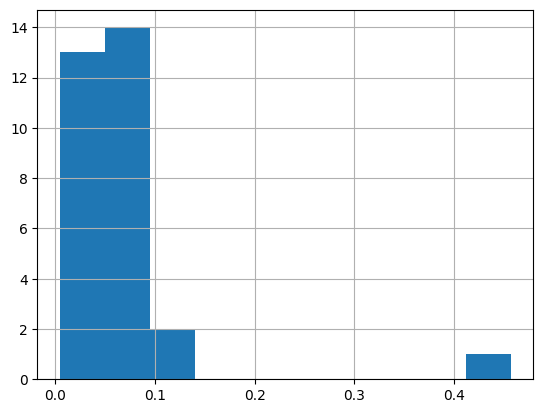

In [21]:
count_big_errors=simulations.groupby(["average_count","n_surrogates"])["out_of_range"].sum()+missing
count_big_errors.name="n_large_errors"
(count_big_errors/m).hist()

In [22]:
pivoted=count_big_errors.reset_index().pivot(index="average_count",columns="n_surrogates",values="n_large_errors")
print("Shape data for line graph")
pivoted/m

Shape data for line graph


n_surrogates,50,100,300,400,500,1000
average_count,,,,,,
5,0.456667,0.086667,0.100000,0.053333,0.061667,0.033333
10,0.086667,0.086667,0.090000,0.043333,0.056667,0.028333
20,0.083333,0.070000,0.071667,0.041667,0.018333,0.036667
30,0.103333,0.073333,0.030000,0.053333,0.038333,0.010000
40,0.085000,0.053333,0.023333,0.006667,0.010000,0.005000


In [23]:
#Set colors that will print well in grayscale,
#Different color for each simulation setting
#other options: YlGnBu,cubehelix,gnuplot
cmap = plt.get_cmap('gnuplot')
indicies = np.linspace(0, cmap.N, len(sim_names))
my_colors = [cmap(int(i)) for i in indicies]

/var/folders/s_/9wh_dsgx63vgx9fj7w1tsprx597k19/T/ipykernel_14094/1481678520.py:2: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=(pivoted/m),markers=True, palette=my_colors)


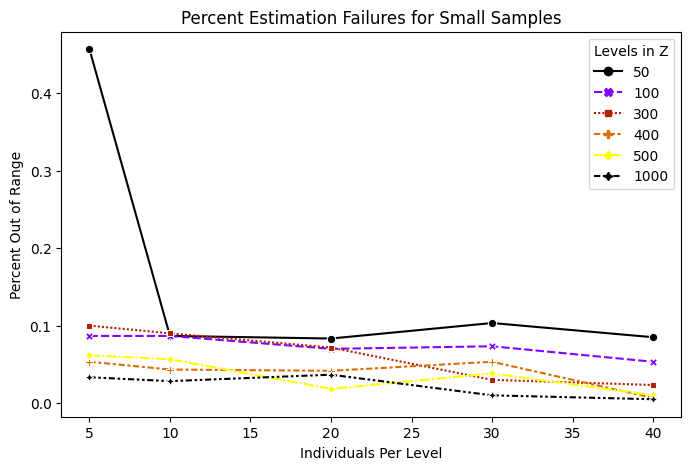

In [24]:
plt.figure(figsize=(8, 5), dpi=100)
sns.lineplot(data=(pivoted/m),markers=True, palette=my_colors)
plt.xlabel("Individuals Per Level")
plt.ylabel("Percent Out of Range")
plt.legend(title="Levels in Z")
plt.title("Percent Estimation Failures for Small Samples")
plt.savefig("percent_out_of_range.png",dpi=300)

# Standard Errors Probabilistic Estimates

We have an understanding of how often the probabilistic estimates fail under different sample sizes. Estimates will vary from sample to sample, however, and the variation decreases with larger samples (more values per surrogate class and more surrogate classes). 

In [25]:
standard_errors=simulations.query('out_of_range==0').groupby(["Metric","simulation","n_surrogates","average_count"])["squared_error"].agg(["sum","count"]).rename(columns={"sum":"probabilistic_sum_of_squares","count":"probabilistic_count"}).merge(df,left_index=True,right_index=True)
standard_errors["probabilistic_se"]=(standard_errors["probabilistic_sum_of_squares"]/(standard_errors["probabilistic_count"]-standard_errors["df"])).apply(np.sqrt)
standard_errors


probabilistic_sum_of_squares  \
Metric             simulation       n_surrogates average_count                                 
Average Odds       extremely_unfair 50           10                                 1.400771   
                                                 20                                 1.013655   
                                                 30                                 0.616997   
                                                 40                                 0.406700   
                                    100          5                                  1.299259   
...                                                                                      ...   
Statistical Parity very_unfair      1000         5                                  0.027871   
                                                 10                                 0.014474   
                                                 20                                 0.006801   
                                                 30                                 0.004502   
                                                 40                                 0.003393   

                                                                probabilistic_count  \
Metric             simulation       n_surrogates average_count                        
Average Odds       extremely_unfair 50           10                              26   
                                                 20                              22   
                                                 30                              21   
                                                 40                              25   
                                    100          5                               22   
...                                                                             ...   
Statistical Parity very_unfair      1000         5                               30   
                                                 10                              30   
                                                 20                              29   
                                                 30                              30   
                                                 40                              29   

                                                                df  \
Metric             simulation       n_surrogates average_count       
Average Odds       extremely_unfair 50           10             16   
                                                 20             16   
                                                 30             16   
                                                 40             16   
                                    100          5              16   
...                                                             ..   
Statistical Parity very_unfair      1000         5               8   
                                                 10              8   
                                                 20              8   
                                                 30              8   
                                                 40              8   

                                                                probabilistic_se  
Metric             simulation       n_surrogates average_count                    
Average Odds       extremely_unfair 50           10                     0.374269  
                                                 20                     0.411026  
                                                 30                     0.351283  
                                                 40                     0.212577  
                                    100          5                      0.465342  
...                                                                          ...  
Statistical Parity very_unfair      1000         5                      0.035593  
                         

<Axes: >

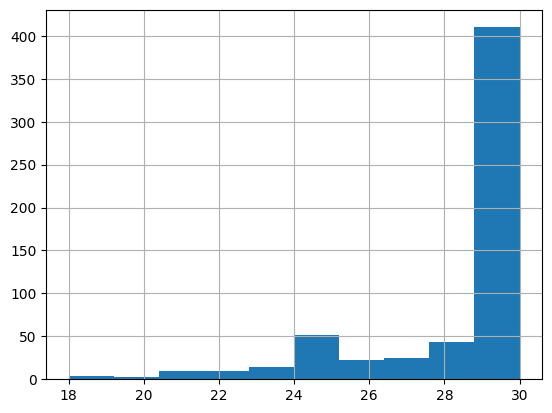

In [26]:
standard_errors["probabilistic_count"].hist()

In [27]:
oracle_std=simulations.query('out_of_range==0').groupby(["Metric","simulation","n_surrogates","average_count"])["oracle_value"].agg(["mean","var","std","count"]).rename(columns={"std":"oracle_std","count":"oracle_count","var":"oracle_var","mean":"oracle_mean"})
oracle_std["oracle_sum_of_squares"]=oracle_std["oracle_var"]*(oracle_std["oracle_count"]-1)
oracle_std


oracle_mean  \
Metric             simulation       n_surrogates average_count                
Average Odds       extremely_unfair 50           10               -0.332308   
                                                 20               -0.332000   
                                                 30               -0.334714   
                                                 40               -0.358400   
                                    100          5                -0.307455   
...                                                                     ...   
Statistical Parity very_unfair      1000         5                -0.413200   
                                                 10               -0.413967   
                                                 20               -0.413448   
                                                 30               -0.412267   
                                                 40               -0.413655   

                                                                oracle_var  \
Metric             simulation       n_surrogates average_count               
Average Odds       extremely_unfair 50           10               0.016266   
                                                 20               0.009308   
                                                 30               0.005208   
                                                 40               0.003703   
                                    100          5                0.016769   
...                                                                    ...   
Statistical Parity very_unfair      1000         5                0.000311   
                                                 10               0.000136   
                                                 20               0.000064   
                                                 30               0.000055   
                                                 40               0.000029   

                                                                oracle_std  \
Metric             simulation       n_surrogates average_count               
Average Odds       extremely_unfair 50           10               0.127536   
                                                 20               0.096480   
                                                 30               0.072164   
                                                 40               0.060852   
                                    100          5                0.129493   
...                                                                    ...   
Statistical Parity very_unfair      1000         5                0.017649   
                                                 10               0.011666   
                                                 20               0.007985   
                                                 30               0.007437   
                                                 40               0.005340   

                                                                oracle_count  \
Metric             simulation       n_surrogates average_count                 
Average Odds       extremely_unfair 50           10                       26   
                                                 20                       22   
                                                 30                       21   
                                                 40                       25   
                                    100          5                        22   
...                                                                      ...   
Statistical Parity very_unfair      1000         5                        30   
                                                 10                       30   
                                                 20                       29   
                                                 30                       30   
                                              

<Axes: >

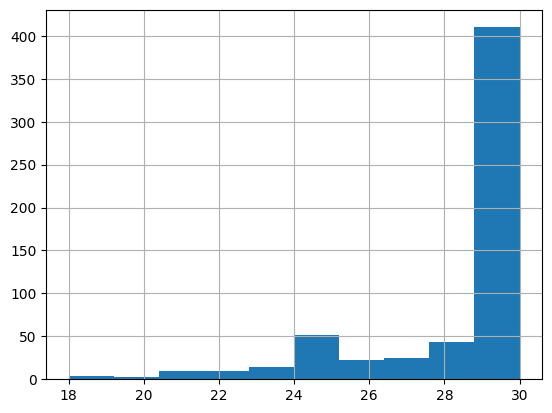

In [28]:
oracle_std["oracle_count"].hist()

In [29]:
compare_errors=standard_errors.merge(oracle_std,left_index=True,right_index=True,how='outer',indicator=True)
compare_errors["std_ratio"]=compare_errors["probabilistic_se"]/compare_errors["oracle_std"]
compare_errors["std_diff"]=(compare_errors["probabilistic_se"]-compare_errors["oracle_std"]).apply(abs)
compare_errors["ss_ratio"]=(compare_errors["probabilistic_sum_of_squares"]/compare_errors["oracle_sum_of_squares"]).apply(abs)
compare_errors["prob_se_oracle_val_ratio"]=(compare_errors["probabilistic_se"]/compare_errors["oracle_mean"]).apply(abs)

compare_errors


probabilistic_sum_of_squares  \
Metric             simulation       n_surrogates average_count                                 
Average Odds       extremely_unfair 50           10                                 1.400771   
                                                 20                                 1.013655   
                                                 30                                 0.616997   
                                                 40                                 0.406700   
                                    100          5                                  1.299259   
...                                                                                      ...   
Statistical Parity very_unfair      1000         5                                  0.027871   
                                                 10                                 0.014474   
                                                 20                                 0.006801   
                                                 30                                 0.004502   
                                                 40                                 0.003393   

                                                                probabilistic_count  \
Metric             simulation       n_surrogates average_count                        
Average Odds       extremely_unfair 50           10                              26   
                                                 20                              22   
                                                 30                              21   
                                                 40                              25   
                                    100          5                               22   
...                                                                             ...   
Statistical Parity very_unfair      1000         5                               30   
                                                 10                              30   
                                                 20                              29   
                                                 30                              30   
                                                 40                              29   

                                                                df  \
Metric             simulation       n_surrogates average_count       
Average Odds       extremely_unfair 50           10             16   
                                                 20             16   
                                                 30             16   
                                                 40             16   
                                    100          5              16   
...                                                             ..   
Statistical Parity very_unfair      1000         5               8   
                                                 10              8   
                                                 20              8   
                                                 30              8   
                                                 40              8   

                                                                probabilistic_se  \
Metric             simulation       n_surrogates average_count                     
Average Odds       extremely_unfair 50           10                     0.374269   
                                                 20                     0.411026   
                                                 30                     0.351283   
                                                 40                     0.212577   
                                    100          5                      0.465342   
...                                                                          ...   
Statistical Parity very_unfair      1000         5                      0.035593   
                

In [30]:
compare_errors["_merge"].value_counts()

both          592
left_only       0
right_only      0
Name: _merge, dtype: int64

In [31]:
def pivot_errors(df,metric_name,simulation_name,values_name):
    query_string=f'Metric=="{metric_name}" & simulation=="{simulation_name}"'
    return df.reset_index().query(query_string).pivot(index="average_count",columns="n_surrogates",values=values_name)

In [32]:
col_name="probabilistic_se"
pivoted_errors=pivot_errors(compare_errors.query('average_count>5'),"Equal Opportunity","fair",col_name)
pivoted_errors


n_surrogates,50,100,300,400,500,1000
average_count,,,,,,
10,0.178950,0.131230,0.074057,0.075282,0.045313,0.042260
20,0.146197,0.095050,0.046240,0.044570,0.035201,0.021683
30,0.154840,0.058909,0.041087,0.034563,0.024559,0.026752
40,0.110500,0.059056,0.021237,0.033892,0.027061,0.021384


/var/folders/s_/9wh_dsgx63vgx9fj7w1tsprx597k19/T/ipykernel_14094/1029826322.py:2: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=(pivoted_errors),markers=True,palette=my_colors)


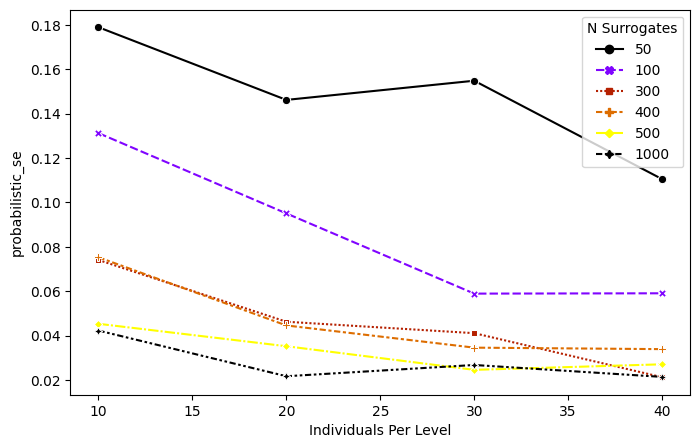

In [33]:
plt.figure(figsize=(8, 5), dpi=100)
sns.lineplot(data=(pivoted_errors),markers=True,palette=my_colors)
plt.xlabel("Individuals Per Level")
plt.ylabel(col_name)
plt.legend(title="N Surrogates")

In [34]:
#In order to show all of the standard deviations on the same graph, 
#We compare the standard deviation of the statistic at each sample size 
#To the large sample statistics reported in the first section. 
large_sample_se=pd.DataFrame.from_dict({"simulation":["fair","fair","fair","fair",
                                        "slightly_unfair","slightly_unfair","slightly_unfair","slightly_unfair",
                                        "moderately_unfair","moderately_unfair","moderately_unfair","moderately_unfair",
                                        "very_unfair","very_unfair","very_unfair","very_unfair",
                                        "extremely_unfair","extremely_unfair","extremely_unfair","extremely_unfair"],
                                        "Metric":["Statistical Parity","Equal Opportunity","Predictive Equality","Average Odds",
                                        "Statistical Parity","Equal Opportunity","Predictive Equality","Average Odds",
                                        "Statistical Parity","Equal Opportunity","Predictive Equality","Average Odds",
                                        "Statistical Parity","Equal Opportunity","Predictive Equality","Average Odds",
                                        "Statistical Parity","Equal Opportunity","Predictive Equality","Average Odds"],
                                        "large_sample_se":[0.005,0.009,0.006,0.006,
                                         0.005,0.013,0.005,0.006,
                                         0.004,0.023,0.004,0.011,
                                         0.005,0.027,0.005,0.013,
                                         0.005,0.029,0.004,0.015]}).set_index(["Metric","simulation"])
large_sample_se


,,large_sample_se
Metric,simulation,
Statistical Parity,fair,0.005
Equal Opportunity,fair,0.009
Predictive Equality,fair,0.006
Average Odds,fair,0.006
Statistical Parity,slightly_unfair,0.005
Equal Opportunity,slightly_unfair,0.013
Predictive Equality,slightly_unfair,0.005
Average Odds,slightly_unfair,0.006
Statistical Parity,moderately_unfair,0.004


In [35]:
compare_to_large=compare_errors.drop(columns=["_merge"]).merge(large_sample_se,left_index=True,right_index=True,how="outer",indicator=True)
print(compare_to_large["_merge"].value_counts())
compare_to_large["small_to_large_se"]=compare_to_large["probabilistic_se"]/compare_to_large["large_sample_se"]
compare_to_large


both          592
left_only       0
right_only      0
Name: _merge, dtype: int64


probabilistic_sum_of_squares  \
Metric             simulation       n_surrogates average_count                                 
Average Odds       extremely_unfair 50           10                                 1.400771   
                                                 20                                 1.013655   
                                                 30                                 0.616997   
                                                 40                                 0.406700   
                                    100          5                                  1.299259   
...                                                                                      ...   
Statistical Parity very_unfair      1000         5                                  0.027871   
                                                 10                                 0.014474   
                                                 20                                 0.006801   
                                                 30                                 0.004502   
                                                 40                                 0.003393   

                                                                probabilistic_count  \
Metric             simulation       n_surrogates average_count                        
Average Odds       extremely_unfair 50           10                              26   
                                                 20                              22   
                                                 30                              21   
                                                 40                              25   
                                    100          5                               22   
...                                                                             ...   
Statistical Parity very_unfair      1000         5                               30   
                                                 10                              30   
                                                 20                              29   
                                                 30                              30   
                                                 40                              29   

                                                                df  \
Metric             simulation       n_surrogates average_count       
Average Odds       extremely_unfair 50           10             16   
                                                 20             16   
                                                 30             16   
                                                 40             16   
                                    100          5              16   
...                                                             ..   
Statistical Parity very_unfair      1000         5               8   
                                                 10              8   
                                                 20              8   
                                                 30              8   
                                                 40              8   

                                                                probabilistic_se  \
Metric             simulation       n_surrogates average_count                     
Average Odds       extremely_unfair 50           10                     0.374269   
                                                 20                     0.411026   
                                                 30                     0.351283   
                                                 40                     0.212577   
                                    100          5                      0.465342   
...                                                                          ...   
Statistical Parity very_unfair      1000         5                      0.035593   
                

In [36]:
col_name="small_to_large_se"
pivoted_errors=pivot_errors(compare_to_large,"Statistical Parity","moderately_unfair",col_name)
pivoted_errors


n_surrogates,50,100,300,400,500,1000
average_count,,,,,,
5,NaN,25.896489,17.617785,14.603082,13.777349,8.457351
10,31.982684,16.590574,10.792551,12.214599,9.682458,6.408889
20,22.797279,14.947161,7.556927,8.315340,5.878505,4.835357
30,16.568213,11.538793,5.952940,4.917443,4.387482,3.195789
40,13.931345,9.773428,4.922121,3.953925,4.354334,2.819877


/var/folders/s_/9wh_dsgx63vgx9fj7w1tsprx597k19/T/ipykernel_14094/3273741071.py:2: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=(pivoted_errors),markers=True,palette=my_colors)


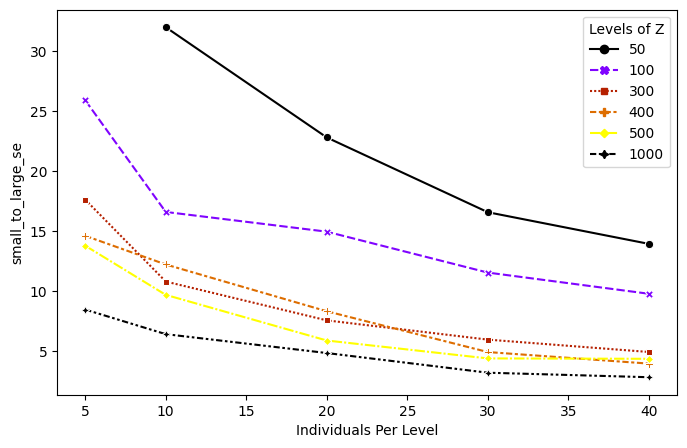

In [37]:
plt.figure(figsize=(8, 5), dpi=100)
sns.lineplot(data=(pivoted_errors),markers=True,palette=my_colors)
plt.xlabel("Individuals Per Level")
plt.ylabel(col_name)
plt.legend(title="Levels of Z")
plt.savefig("standard_error_ratio.png",dpi=300)

/var/folders/s_/9wh_dsgx63vgx9fj7w1tsprx597k19/T/ipykernel_14094/3377951155.py:3: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(data=(pivoted_errors),markers=True,palette=my_colors)


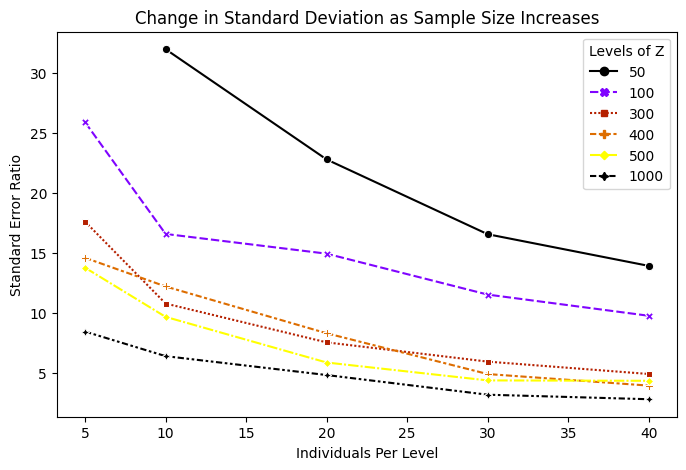

In [38]:
pivoted_errors=pivot_errors(compare_to_large,"Statistical Parity","moderately_unfair","small_to_large_se")
plt.figure(figsize=(8, 5), dpi=100)
sns.lineplot(data=(pivoted_errors),markers=True,palette=my_colors)
plt.xlabel("Individuals Per Level")
plt.ylabel("Standard Error Ratio")
plt.legend(title="Levels of Z")
plt.title("Change in Standard Deviation as Sample Size Increases")
plt.savefig("standard_error_ratio.png",dpi=300)

In [39]:
compare_to_large.groupby(["Metric","simulation"])["small_to_large_se"].max()

Metric               simulation       
Average Odds         extremely_unfair     31.022799
                     fair                 34.018526
                     moderately_unfair    54.912440
                     slightly_unfair      73.258999
                     very_unfair          42.324813
Equal Opportunity    extremely_unfair     21.039590
                     fair                 33.880035
                     moderately_unfair    34.391143
                     slightly_unfair      46.786413
                     very_unfair          26.406198
Predictive Equality  extremely_unfair     20.138865
                     fair                 30.098801
                     moderately_unfair    29.344982
                     slightly_unfair      27.736733
                     very_unfair          33.032923
Statistical Parity   extremely_unfair     26.942090
                     fair                 34.281561
                     moderately_unfair    31.982684
                     slig

In [40]:
compare_to_large.groupby(["Metric","simulation"])["small_to_large_se"].min()

Metric               simulation       
Average Odds         extremely_unfair     2.899097
                     fair                 2.416051
                     moderately_unfair    2.559562
                     slightly_unfair      4.312220
                     very_unfair          3.493931
Equal Opportunity    extremely_unfair     2.313933
                     fair                 2.359640
                     moderately_unfair    2.029978
                     slightly_unfair      3.301059
                     very_unfair          2.603045
Predictive Equality  extremely_unfair     2.279479
                     fair                 1.848764
                     moderately_unfair    3.112018
                     slightly_unfair      2.186737
                     very_unfair          2.335497
Statistical Parity   extremely_unfair     2.689035
                     fair                 2.300198
                     moderately_unfair    2.819877
                     slightly_unfair      2

In [41]:
average_ratio=compare_to_large.groupby(["average_count","n_surrogates"])[["probabilistic_se","large_sample_se"]].mean()
average_ratio["se_ratio"]=average_ratio["probabilistic_se"]/average_ratio["large_sample_se"]
average_ratio


probabilistic_se  large_sample_se   se_ratio
average_count n_surrogates                                              
5             50                    0.315713          0.00875  36.081469
              100                   0.294178          0.01000  29.417778
              300                   0.170695          0.01000  17.069506
              400                   0.141937          0.01000  14.193727
              500                   0.124460          0.01000  12.445997
              1000                  0.078519          0.01000   7.851926
10            50                    0.284701          0.01000  28.470057
              100                   0.187965          0.01000  18.796539
              300                   0.114504          0.01000  11.450357
              400                   0.088459          0.01000   8.845898
              500                   0.076873          0.01000   7.687338
              1000                  0.051142          0.01000   5.114184
20            50                    0.212469          0.01000  21.246893
              100                   0.137857          0.01000  13.785687
              300                   0.074436          0.01000   7.443642
              400                   0.069738          0.01000   6.973847
              500                   0.058116          0.01000   5.811568
              1000                  0.038450          0.01000   3.845032
30            50                    0.170757          0.01000  17.075735
              100                   0.109066          0.01000  10.906633
              300                   0.059213          0.01000   5.921254
              400                   0.050148          0.01000   5.014825
              500                   0.040596          0.01000   4.059623
              1000                  0.030429          0.01000   3.042903
40            50                    0.146803          0.01000  14.680332
              100                   0.096735          0.01000   9.673524
              300                   0.048268          0.01000   4.826794
              400                   0.041226          0.01000   4.122641
              500                   0.034852          0.01000   3.485152
              1000                  0.026180          0.01000   2.617997

In [42]:
col_name="se_ratio"
pivoted_errors=pd.pivot(average_ratio.reset_index(),index="average_count",columns="n_surrogates",values=col_name)
pivoted_errors


n_surrogates,50,100,300,400,500,1000
average_count,,,,,,
5,36.081469,29.417778,17.069506,14.193727,12.445997,7.851926
10,28.470057,18.796539,11.450357,8.845898,7.687338,5.114184
20,21.246893,13.785687,7.443642,6.973847,5.811568,3.845032
30,17.075735,10.906633,5.921254,5.014825,4.059623,3.042903
40,14.680332,9.673524,4.826794,4.122641,3.485152,2.617997


Standard errors continue to decrease as the number of levels of $Z$ and the number of individuals per level increase. Note that the estimates for Equal Opportunity, and therefore to a lesser extent Average Odds, are particulary poor for small samples. This is consistent with the higher standard errors for those probabilistic estimates (see Table ). For applications where Equal Opportunity is of particular interest, minimum sample size recommendations should be heeded with particular interest, and it is suggested that practitioners use the higher range of the recommendations described below. See: Rodolfa, Kit T., et al. "Case study: predictive fairness to reduce misdemeanor recidivism through social service interventions." Proceedings of the 2020 Conference on Fairness, Accountability, and Transparency. 2020. for an analysis of the most critical fairness metrics under different use cases. 

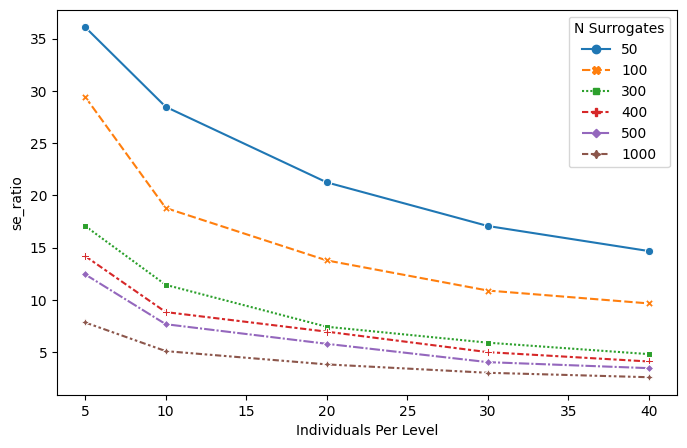

In [43]:
plt.figure(figsize=(8, 5), dpi=100)
sns.lineplot(data=(pivoted_errors),markers=True)
plt.xlabel("Individuals Per Level")
plt.ylabel(col_name)
plt.legend(title="N Surrogates")
plt.savefig("change_in_standard_deviation.png",dpi=300)